In [3]:
import numpy as np 
import pandas as pd 
from tqdm import tqdm
import glob
import os
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns
import pprint
import pydicom as dicom
from pydicom.pixel_data_handlers.util import apply_voi_lut
import albumentations as A
import cv2
import wandb

from PIL import Image
from colorama import Fore, Back, Style
# colored output
y_ = Fore.YELLOW
r_ = Fore.RED
g_ = Fore.GREEN
b_ = Fore.BLUE
m_ = Fore.MAGENTA

sns.set(font="Serif",style ="white")

In [20]:
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
wandb_api_key = user_secrets.get_secret("wandb-api-key")

os.environ["WANDB_SILENT"] = "true"
CONFIG = {'competition': 'siim-fisabio-rsna-covid-19-detection', '_wandb_kernel': 'saifmu6'}
!wandb login $wandb_api_key
# 1. Start a W&B run
#run = wandb.init(project='siim-fisabio-rsna-covid-19-detection', entity='saifmu6')

In [3]:
from os import listdir, mkdir

BASE_DIR = "../../"
DATASET_PATH = "../../input/siim-covid19-detection/"
print(listdir(DATASET_PATH))

['sample_submission.csv', 'train_image_level.csv', 'test', 'train', 'train_study_level.csv']


In [4]:
# Read in metadata
train_study_df = pd.read_csv(f"{DATASET_PATH}/train_study_level.csv")
train_image_df = pd.read_csv(f"{DATASET_PATH}/train_image_level.csv")

In [7]:
train_study_df.head()

,id,Negative for Pneumonia,Typical Appearance,Indeterminate Appearance,Atypical Appearance
0,00086460a852_study,0,1,0,0
1,000c9c05fd14_study,0,0,0,1
2,00292f8c37bd_study,1,0,0,0
3,005057b3f880_study,1,0,0,0
4,0051d9b12e72_study,0,0,0,1


In [8]:
train_image_df.head()

,id,boxes,label,StudyInstanceUID
0,000a312787f2_image,"[{'x': 789.28836, 'y': 582.43035, 'width': 102...",opacity 1 789.28836 582.43035 1815.94498 2499....,5776db0cec75
1,000c3a3f293f_image,NaN,none 1 0 0 1 1,ff0879eb20ed
2,0012ff7358bc_image,"[{'x': 677.42216, 'y': 197.97662, 'width': 867...",opacity 1 677.42216 197.97662 1545.21983 1197....,9d514ce429a7
3,001398f4ff4f_image,"[{'x': 2729, 'y': 2181.33331, 'width': 948.000...",opacity 1 2729 2181.33331 3677.00012 2785.33331,28dddc8559b2
4,001bd15d1891_image,"[{'x': 623.23328, 'y': 1050, 'width': 714, 'he...",opacity 1 623.23328 1050 1337.23328 2156 opaci...,dfd9fdd85a3e


### train_image_df might have:
1. Multiple boxes for a Single Image 
2. StudyInstanceUID is Equal to the train_study_df's id without "_image" 


In [8]:
train_image_df.boxes[3]

"[{'x': 2729, 'y': 2181.33331, 'width': 948.00012, 'height': 604}]"

In [9]:
# Create Train Dataset
train_directory = f"{DATASET_PATH}train/"
test_directory = f"{DATASET_PATH}test/"

train_study_df['StudyInstanceUID'] = train_study_df['id'].apply(lambda x: x.replace('_study', ''))
del train_study_df['id']
train_df = train_image_df.merge(train_study_df, on='StudyInstanceUID')

In [10]:
train_df.head()

,id,boxes,label,StudyInstanceUID,Negative for Pneumonia,Typical Appearance,Indeterminate Appearance,Atypical Appearance
0,000a312787f2_image,"[{'x': 789.28836, 'y': 582.43035, 'width': 102...",opacity 1 789.28836 582.43035 1815.94498 2499....,5776db0cec75,0,1,0,0
1,000c3a3f293f_image,NaN,none 1 0 0 1 1,ff0879eb20ed,1,0,0,0
2,0012ff7358bc_image,"[{'x': 677.42216, 'y': 197.97662, 'width': 867...",opacity 1 677.42216 197.97662 1545.21983 1197....,9d514ce429a7,0,1,0,0
3,001398f4ff4f_image,"[{'x': 2729, 'y': 2181.33331, 'width': 948.000...",opacity 1 2729 2181.33331 3677.00012 2785.33331,28dddc8559b2,0,0,0,1
4,001bd15d1891_image,"[{'x': 623.23328, 'y': 1050, 'width': 714, 'he...",opacity 1 623.23328 1050 1337.23328 2156 opaci...,dfd9fdd85a3e,0,1,0,0


In [11]:
# Create Training Paths
training_paths = []

for sid in tqdm(train_df['StudyInstanceUID']):
    training_paths.append(glob.glob(os.path.join(train_directory, sid +"/*/*"))[0])

train_df['path'] = training_paths

100%|██████████| 6334/6334 [00:24<00:00, 254.28it/s]


In [12]:
train_df.head()

,id,boxes,label,StudyInstanceUID,Negative for Pneumonia,Typical Appearance,Indeterminate Appearance,Atypical Appearance,path
0,000a312787f2_image,"[{'x': 789.28836, 'y': 582.43035, 'width': 102...",opacity 1 789.28836 582.43035 1815.94498 2499....,5776db0cec75,0,1,0,0,../../input/siim-covid19-detection/train/5776d...
1,000c3a3f293f_image,NaN,none 1 0 0 1 1,ff0879eb20ed,1,0,0,0,../../input/siim-covid19-detection/train/ff087...
2,0012ff7358bc_image,"[{'x': 677.42216, 'y': 197.97662, 'width': 867...",opacity 1 677.42216 197.97662 1545.21983 1197....,9d514ce429a7,0,1,0,0,../../input/siim-covid19-detection/train/9d514...
3,001398f4ff4f_image,"[{'x': 2729, 'y': 2181.33331, 'width': 948.000...",opacity 1 2729 2181.33331 3677.00012 2785.33331,28dddc8559b2,0,0,0,1,../../input/siim-covid19-detection/train/28ddd...
4,001bd15d1891_image,"[{'x': 623.23328, 'y': 1050, 'width': 714, 'he...",opacity 1 623.23328 1050 1337.23328 2156 opaci...,dfd9fdd85a3e,0,1,0,0,../../input/siim-covid19-detection/train/dfd9f...


In [13]:
DIR = "../input/"
train_df.to_csv(f"{DIR}train_df.csv", index=False)

### Distribution of Different Class Labels

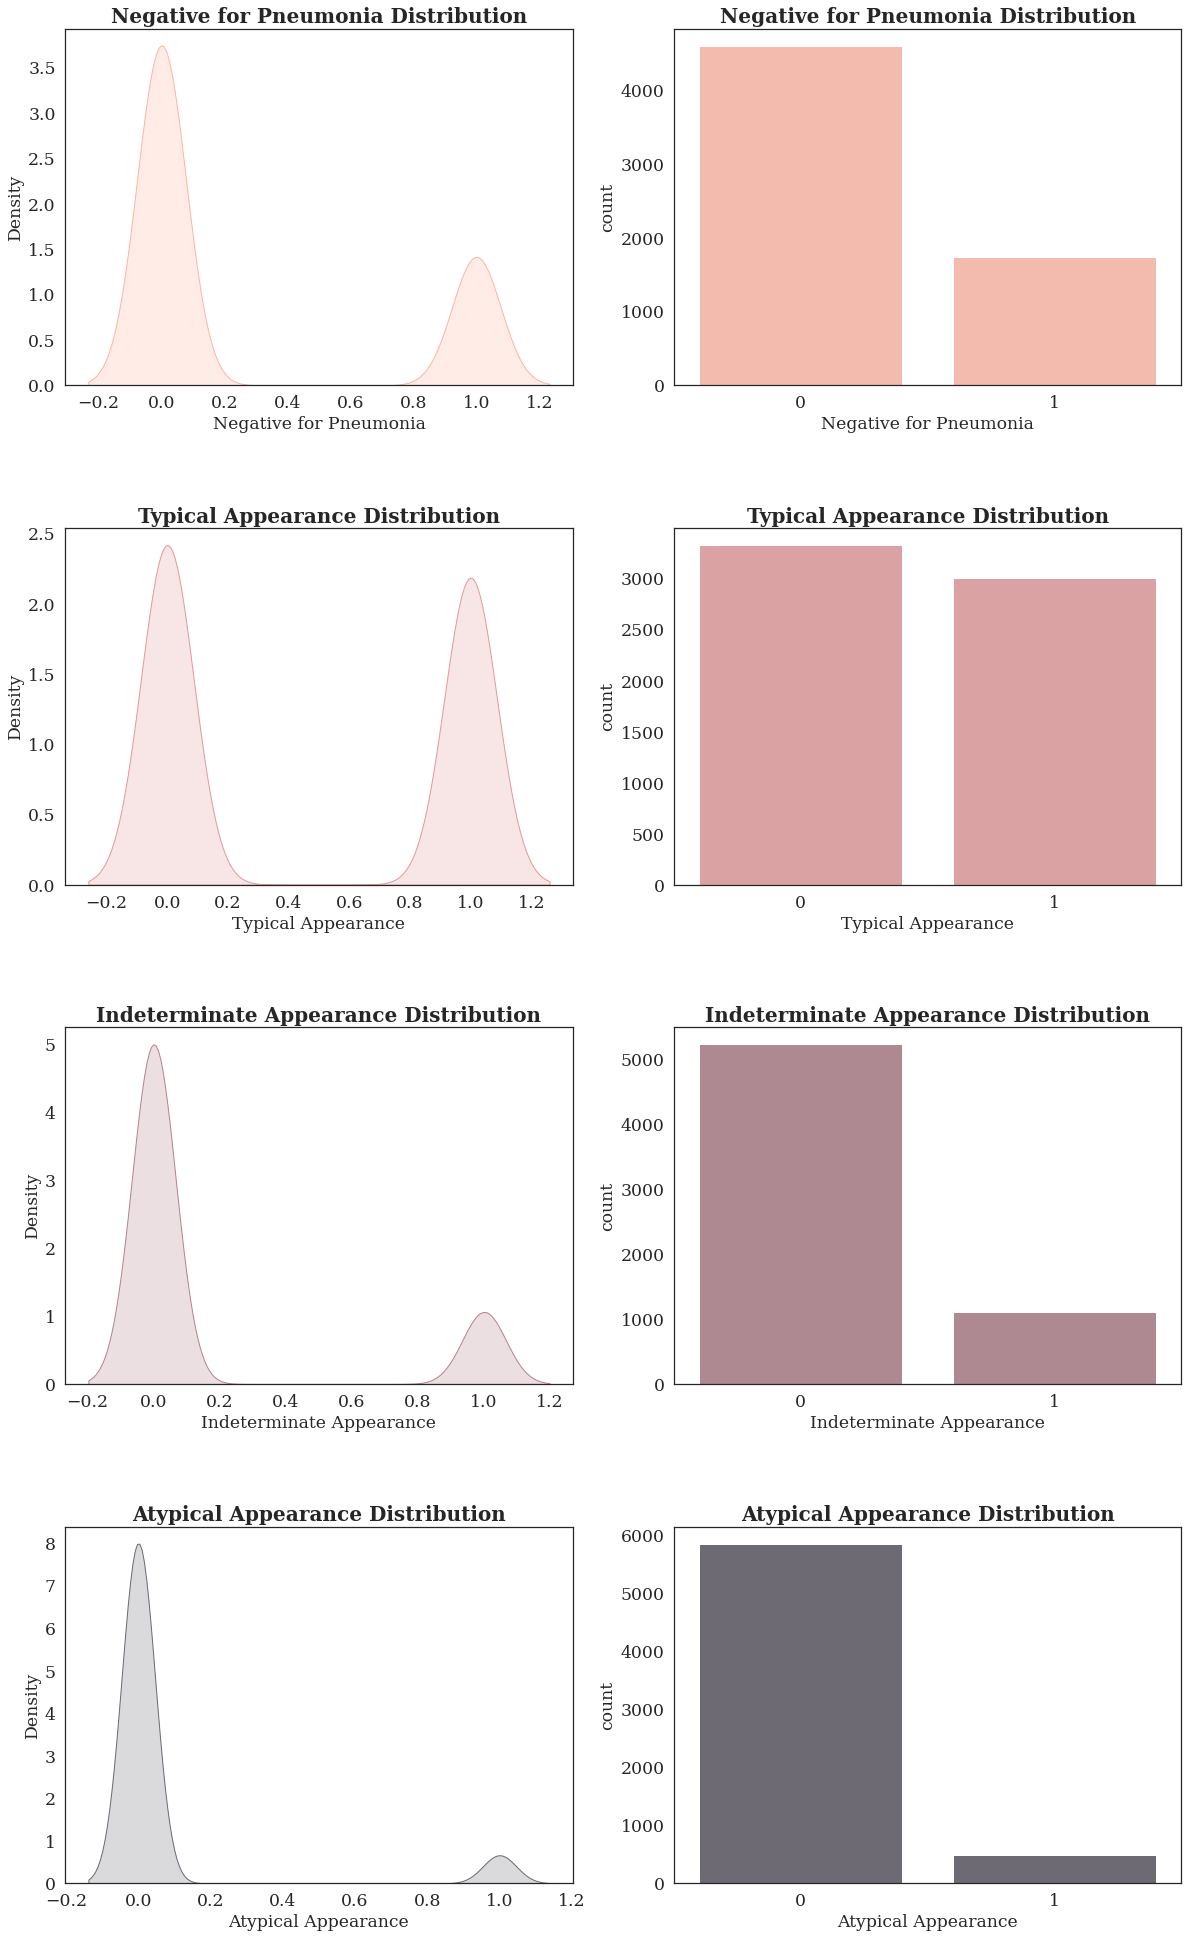

In [18]:
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (20, 32),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

fig, ax = plt.subplots(4,2)
sns.kdeplot(train_df["Negative for Pneumonia"], shade=True,ax=ax[0,0],color="#ffb4a2")
ax[0,0].set_title("Negative for Pneumonia Distribution",font="Serif", fontsize=20,weight="bold")
sns.countplot(x = train_df["Negative for Pneumonia"], ax=ax[0,1],color="#ffb4a2")
ax[0,1].set_title("Negative for Pneumonia Distribution",font="Serif", fontsize=20,weight="bold")

sns.kdeplot(train_df["Typical Appearance"], shade=True,ax=ax[1,0],color="#e5989b")
ax[1,0].set_title("Typical Appearance Distribution",font="Serif", fontsize=20,weight="bold")
sns.countplot(x = train_df["Typical Appearance"], ax=ax[1,1],color="#e5989b")
ax[1,1].set_title("Typical Appearance Distribution",font="Serif", fontsize=20,weight="bold")

sns.kdeplot(train_df["Indeterminate Appearance"], shade=True,ax=ax[2,0],color="#b5838d")
ax[2,0].set_title("Indeterminate Appearance Distribution",font="Serif", fontsize=20,weight="bold")
sns.countplot(x = train_df["Indeterminate Appearance"], ax=ax[2,1],color="#b5838d")
ax[2,1].set_title("Indeterminate Appearance Distribution",font="Serif", fontsize=20,weight="bold")

sns.kdeplot(train_df["Atypical Appearance"], shade=True,ax=ax[3,0],color="#6d6875")
ax[3,0].set_title("Atypical Appearance Distribution",font="Serif", fontsize=20,weight="bold")
sns.countplot(x = train_df["Atypical Appearance"], ax=ax[3,1],color="#6d6875")
ax[3,1].set_title("Atypical Appearance Distribution",font="Serif", fontsize=20,weight="bold")

fig.subplots_adjust(wspace=0.2, hspace=0.4, top=0.93)
plt.show()

In [21]:
#====== Function to plot WandB bar chart ======
def plot_wb_bar(df,col1,col2): 
    run = wandb.init(project='siim-fisabio-rsna-covid-19-detection', job_type='image-visualization',name=col1,config = CONFIG)
    
    dt = [[label, val] for (label, val) in zip(df[col1], df[col2])]
    table = wandb.Table(data=dt, columns = [col1,col2])
    wandb.log({col1 : wandb.plot.bar(table, col1,col2,title=col1)})

    run.finish()
    
#====== Function to create a dataframe of value counts ======
def count_values(df,col):
    df = pd.DataFrame(df[col].value_counts().reset_index().values,columns=[col, "counts"])
    return df

plot_wb_bar(count_values(train_df,"Negative for Pneumonia"),"Negative for Pneumonia", 'counts')
plot_wb_bar(count_values(train_df,"Typical Appearance"),"Typical Appearance", 'counts')
plot_wb_bar(count_values(train_df,"Indeterminate Appearance"),"Indeterminate Appearance", 'counts')
plot_wb_bar(count_values(train_df,"Atypical Appearance"),"Atypical Appearance", 'counts')

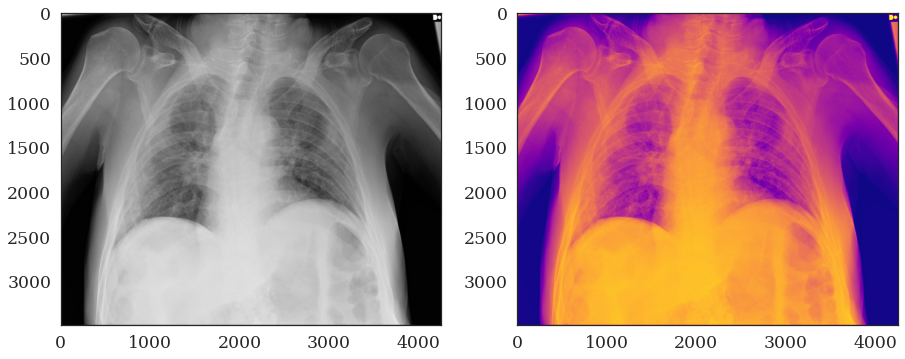

{'Accession Number': 'f6cd7f2019f5',
 'Bits Allocated': 16,
 'Bits Stored': 12,
 'Body Part Examined': 'CHEST',
 'Columns': 4256,
 'De-identification Method': 'CTP Default:  based on DICOM PS3.15 AnnexE. '
                             'Details in 0012,0064',
 'De-identification Method Code Sequence': '<Sequence, length 6>',
 'High Bit': 11,
 'Image Type': "['ORIGINAL', 'PRIMARY']",
 'Imager Pixel Spacing': '[0.1, 0.1]',
 'Instance Number': 1,
 'Modality': 'DX',
 'Patient ID': 'dcc3fdf6426a',
 "Patient's Name": "'d4268f26ed05'",
 "Patient's Sex": 'M',
 'Photometric Interpretation': 'MONOCHROME2',
 'Rows': 3488,
 'SOP Class UID': "'71228e4340de'",
 'SOP Instance UID': "'000a312787f2'",
 'Samples per Pixel': 1,
 'Series Instance UID': "'81456c9c5423'",
 'Series Number': 1,
 'Specific Character Set': 'ISO_IR 100',
 'Study Date': '526316e376d4',
 'Study ID': '55625fb42f3f',
 'Study Instance UID': "'5776db0cec75'",
 'Study Time': '8ccfb6acf07f'}


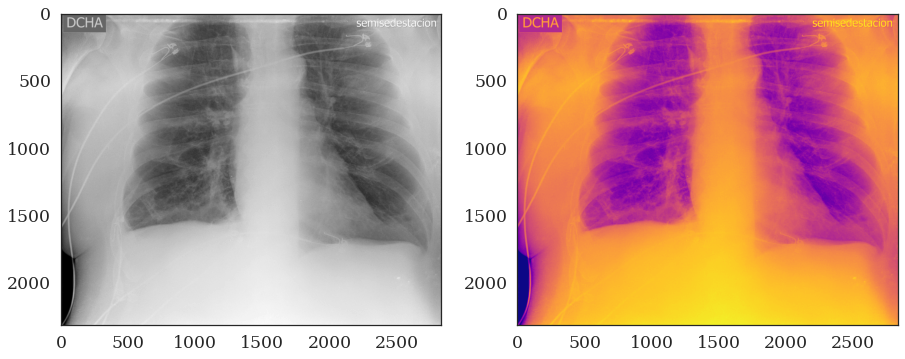

{'Accession Number': '1c2708371bc6',
 'Bits Allocated': 8,
 'Bits Stored': 8,
 'Body Part Examined': 'CHEST',
 'Columns': 2832,
 'De-identification Method': 'CTP Default:  based on DICOM PS3.15 AnnexE. '
                             'Details in 0012,0064',
 'De-identification Method Code Sequence': '<Sequence, length 6>',
 'High Bit': 7,
 'Image Type': "['ORIGINAL', 'PRIMARY']",
 'Imager Pixel Spacing': '[0.15, 0.15]',
 'Instance Number': 1,
 'Modality': 'CR',
 'Patient ID': 'f09ff9b7dab3',
 "Patient's Name": "'ef8c31f8dfdd'",
 "Patient's Sex": 'M',
 'Photometric Interpretation': 'MONOCHROME2',
 'Rows': 2320,
 'SOP Class UID': "'03a65300fa41'",
 'SOP Instance UID': "'000c3a3f293f'",
 'Samples per Pixel': 1,
 'Series Instance UID': "'d8a644cc4f93'",
 'Series Number': 1,
 'Specific Character Set': 'ISO_IR 100',
 'Study Date': 'd09eda152722',
 'Study ID': '55625fb42f3f',
 'Study Instance UID': "'ff0879eb20ed'",
 'Study Time': '543adb46f494'}


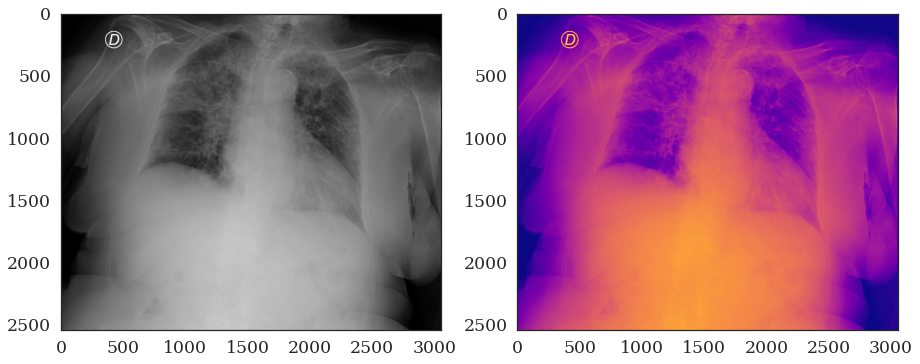

{'Accession Number': '99428f65d948',
 'Bits Allocated': 16,
 'Bits Stored': 12,
 'Body Part Examined': 'PORT CHEST',
 'Columns': 3056,
 'De-identification Method': 'CTP Default:  based on DICOM PS3.15 AnnexE. '
                             'Details in 0012,0064',
 'De-identification Method Code Sequence': '<Sequence, length 6>',
 'High Bit': 11,
 'Image Type': "['DERIVED', 'PRIMARY']",
 'Imager Pixel Spacing': '[0.139, 0.139]',
 'Instance Number': 1,
 'Modality': 'DX',
 'Patient ID': '6a02c0731039',
 "Patient's Name": "'2f2fb944fe44'",
 "Patient's Sex": 'F',
 'Photometric Interpretation': 'MONOCHROME2',
 'Rows': 2544,
 'SOP Class UID': "'71228e4340de'",
 'SOP Instance UID': "'0012ff7358bc'",
 'Samples per Pixel': 1,
 'Series Instance UID': "'22897cd1daa0'",
 'Series Number': 1,
 'Specific Character Set': 'ISO_IR 100',
 'Study Date': '96fc21dd2b1f',
 'Study ID': '55625fb42f3f',
 'Study Instance UID': "'9d514ce429a7'",
 'Study Time': '746186a2bbf2'}


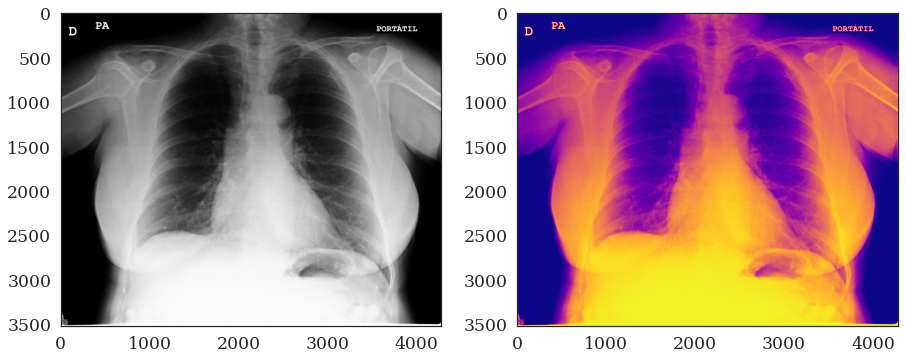

{'Accession Number': '7b889627faf1',
 'Bits Allocated': 16,
 'Bits Stored': 12,
 'Body Part Examined': 'CHEST',
 'Columns': 4280,
 'De-identification Method': 'CTP Default:  based on DICOM PS3.15 AnnexE. '
                             'Details in 0012,0064',
 'De-identification Method Code Sequence': '<Sequence, length 6>',
 'High Bit': 11,
 'Image Type': "['DERIVED', 'PRIMARY', 'POST_PROCESSED', 'RT', '', '', '', '', "
               "'100000']",
 'Imager Pixel Spacing': '[0.1, 0.1]',
 'Instance Number': 1002,
 'Modality': 'CR',
 'Patient ID': 'db63d9b7f61c',
 "Patient's Name": "'9ccd87b4511b'",
 "Patient's Sex": 'F',
 'Photometric Interpretation': 'MONOCHROME1',
 'Private Creator': 'GEIIS',
 'Rows': 3520,
 'SOP Class UID': "'03a65300fa41'",
 'SOP Instance UID': "'001398f4ff4f'",
 'Samples per Pixel': 1,
 'Series Instance UID': "'4d47bc042ee6'",
 'Series Number': 1002,
 'Specific Character Set': 'ISO_IR 100',
 'Study Date': '3f094e1700ec',
 'Study ID': '55625fb42f3f',
 'Study Instance

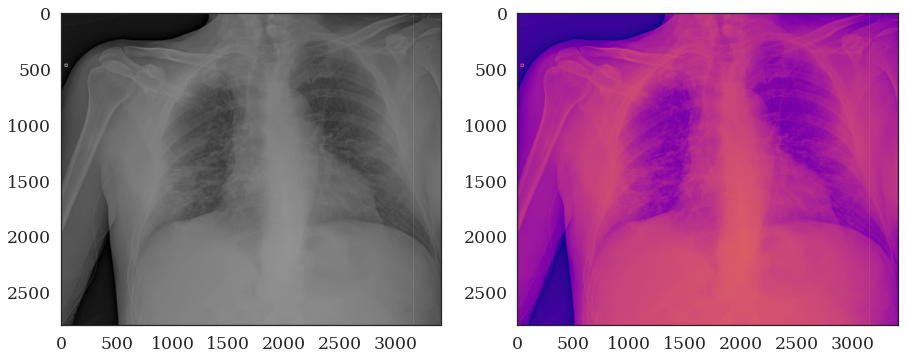

{'Accession Number': 'e9d93edf50c6',
 'Bits Allocated': 16,
 'Bits Stored': 15,
 'Body Part Examined': 'CHEST',
 'Columns': 3408,
 'De-identification Method': 'CTP Default:  based on DICOM PS3.15 AnnexE. '
                             'Details in 0012,0064',
 'De-identification Method Code Sequence': '<Sequence, length 6>',
 'High Bit': 14,
 'Image Type': "['ORIGINAL', 'PRIMARY']",
 'Imager Pixel Spacing': '[0.125, 0.125]',
 'Instance Number': 1,
 'Modality': 'DX',
 'Patient ID': '605693f36f43',
 "Patient's Name": "'35bf9ddbf9e9'",
 "Patient's Sex": 'M',
 'Photometric Interpretation': 'MONOCHROME1',
 'Rows': 2800,
 'SOP Class UID': "'71228e4340de'",
 'SOP Instance UID': "'001bd15d1891'",
 'Samples per Pixel': 1,
 'Series Instance UID': "'49170afa4f27'",
 'Series Number': 1,
 'Specific Character Set': 'ISO_IR 100',
 'Study Date': 'a69d89c8a474',
 'Study ID': '55625fb42f3f',
 'Study Instance UID': "'dfd9fdd85a3e'",
 'Study Time': '5399ff949226'}


In [22]:
voi_lut=True
fix_monochrome=True

def dicom_dataset_to_dict(filename,func):
    """Credit: https://github.com/pydicom/pydicom/issues/319
               https://www.kaggle.com/raddar/convert-dicom-to-np-array-the-correct-way
    """
    
    dicom_header = dicom.dcmread(filename) 
    
    #====== DICOM FILE DATA ======
    dicom_dict = {}
    repr(dicom_header)
    for dicom_value in dicom_header.values():
        if dicom_value.tag == (0x7fe0, 0x0010):
            #discard pixel data
            continue
        if type(dicom_value.value) == dicom.dataset.Dataset:
            dicom_dict[dicom_value.name] = dicom_dataset_to_dict(dicom_value.value)
        else:
            v = _convert_value(dicom_value.value)
            dicom_dict[dicom_value.name] = v
      
    del dicom_dict['Pixel Representation']
    
    if func!='metadata_df':
        #====== DICOM IMAGE DATA ======
        # VOI LUT (if available by DICOM device) is used to transform raw DICOM data to "human-friendly" view
        if voi_lut:
            data = apply_voi_lut(dicom_header.pixel_array, dicom_header)
        else:
            data = dicom_header.pixel_array
        # depending on this value, X-ray may look inverted - fix that:
        if fix_monochrome and dicom_header.PhotometricInterpretation == "MONOCHROME1":
            data = np.amax(data) - data
        data = data - np.min(data)
        data = data / np.max(data)
        modified_image_data = (data * 255).astype(np.uint8)
    
        return dicom_dict, modified_image_data
    
    else:
        return dicom_dict

def _sanitise_unicode(s):
    return s.replace(u"\u0000", "").strip()

def _convert_value(v):
    t = type(v)
    if t in (list, int, float):
        cv = v
    elif t == str:
        cv = _sanitise_unicode(v)
    elif t == bytes:
        s = v.decode('ascii', 'replace')
        cv = _sanitise_unicode(s)
    elif t == dicom.valuerep.DSfloat:
        cv = float(v)
    elif t == dicom.valuerep.IS:
        cv = int(v)
    else:
        cv = repr(v)
    return cv

for filename in train_df.path[0:5]:
    df, img_array = dicom_dataset_to_dict(filename, 'fetch_both_values')
    
    fig, ax = plt.subplots(1, 2, figsize=[15, 8])
    ax[0].imshow(img_array, cmap=plt.cm.gray)
    ax[1].imshow(img_array, cmap=plt.cm.plasma)    
    plt.show()
    
    pprint.pprint(df)